### Import Libraries and Modules

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm

parent_path = os.path.dirname(os.getcwd()) # Get parent path (if using .ipynb file)
# parent_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) # Get parent path (if using .py file)
os.chdir(parent_path) # Set parent path as working directory (for reading and writing files)
sys.path.insert(0, parent_path) # Add parent path to system path (for importing modules)

import utils.portfolio_management_functions as pm

# Set Global Variables:
PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

### Check Excel file

In [2]:
# Check data in the file (sheets, columns, data):
try:
    pm.read_excel_default("data/spy_data.xlsx", print_sheets = True)
except FileNotFoundError as e:
    print(f'{e}.\nCheck file in {parent_path}')
    


Sheet name: descriptions
Columns: ticker, quoteType, shortName, volume, totalAssets, trailingAnnualDividendYield, longBusinessSummary
  ticker quoteType              shortName          volume          totalAssets  trailingAnnualDividendYield                                longBusinessSummary
0    SPY       ETF           SPDR S&P 500 12,008,369.0000 562,499,813,376.0000                       0.0109  The Trust seeks to achieve its investment obje...
1   ^IRX     INDEX  13 WEEK TREASURY BILL             NaN                  NaN                          NaN                                                NaN
----------------------------------------------------------------------


Sheet name: total returns
Columns: date, SPY, ^IRX
        date    SPY   ^IRX
0 1994-01-04 0.0040 0.0001
1 1994-01-05 0.0020 0.0001
2 1994-01-06 0.0000 0.0001
----------------------------------------------------------------------


Sheet name: prices
Columns: date, SPY, ^IRX
        date     SPY   ^IRX
0 1994-01-03

### Import Data and perform high level check

In [3]:
# Import data from the file:
total_returns = pd.read_excel('data/spy_data.xlsx',sheet_name='total returns',index_col=0)
prices = pd.read_excel('data/spy_data.xlsx',sheet_name='prices',index_col=0)

In [4]:
# Check for potential outliers and nan values:
print(total_returns.describe())
print('\nNumber of NAN values in total returns: ')
print(total_returns.isna().sum())
print()
print(prices.describe())
print('\nNumber of NAN values in prices: ')
print(prices.isna().sum())

             SPY       ^IRX
count 7,680.0000 7,680.0000
mean      0.0005     0.0001
std       0.0119     0.0001
min      -0.1094    -0.0000
25%      -0.0046     0.0000
50%       0.0007     0.0001
75%       0.0061     0.0002
max       0.1452     0.0002

Number of NAN values in total returns: 
SPY     0
^IRX    0
dtype: int64

             SPY       ^IRX
count 7,681.0000 7,681.0000
mean    152.0718     2.3505
std     121.7583     2.1198
min      25.4320    -0.1050
25%      73.8504     0.1350
50%      95.9733     1.7100
75%     197.8195     4.7520
max     564.8600     6.2200

Number of NAN values in prices: 
SPY     0
^IRX    0
dtype: int64


,SPY,^IRX
date,,
2024-07-29,0.0006,0.0002
2024-07-30,-0.0051,0.0002
2024-07-31,0.0163,0.0002
2024-08-01,-0.0142,0.0002
2024-08-02,-0.0186,0.0002


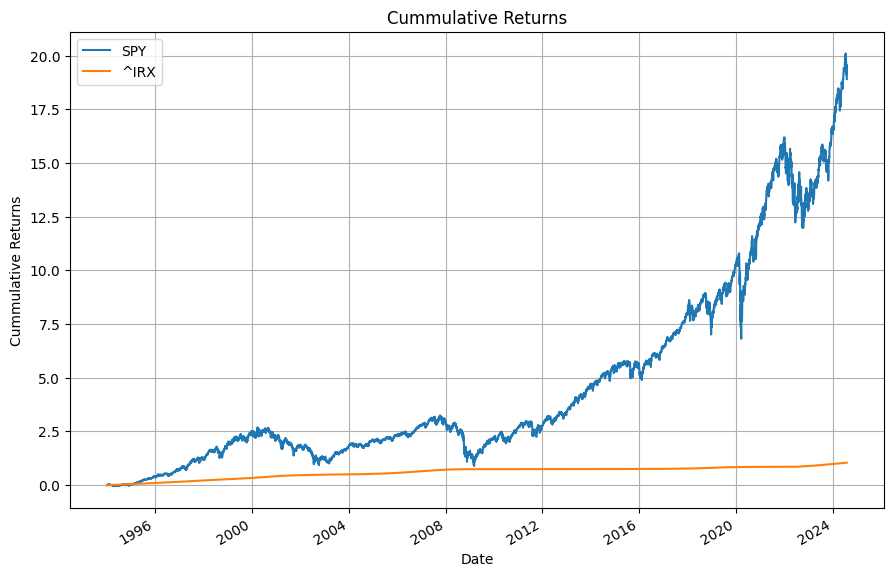

In [5]:
# Plot the data:
pm.calc_cummulative_returns(total_returns)

# Check tail of the data:
display(total_returns.tail(5))

In [6]:
# Get the SPY excess returns:
spy_excess_returns = total_returns.assign(SPY=lambda x: x['SPY'] - x['^IRX']).drop('^IRX', axis=1)
display(spy_excess_returns.tail(5))

,SPY
date,
2024-07-29,0.0004
2024-07-30,-0.0053
2024-07-31,0.0161
2024-08-01,-0.0144
2024-08-02,-0.0188


***

### Historic and Parametric Var

In [7]:
# To avoid forward-looking bias, use historic sample up to time t-1:
spy_excess_returns_var = spy_excess_returns.copy()
spy_excess_returns_var["SPY Shifted"] = spy_excess_returns_var["SPY"].shift(1)
spy_excess_returns_var

,SPY,SPY Shifted
date,,
1994-01-04,0.0039,NaN
1994-01-05,0.0019,0.0039
1994-01-06,-0.0001,0.0019
1994-01-07,0.0059,-0.0001
1994-01-10,0.0118,0.0059
...,...,...
2024-07-29,0.0004,0.0110
2024-07-30,-0.0053,0.0004
2024-07-31,0.0161,-0.0053


In [8]:
# Historical Var (Rolling window = 60):
spy_excess_returns_var["SPY Historical VaR 5%"] = (
    spy_excess_returns_var["SPY Shifted"].expanding(min_periods=60).quantile(.05)
)
spy_excess_returns_var = spy_excess_returns_var.loc["2001-01-01":]
spy_excess_returns_var

,SPY,SPY Shifted,SPY Historical VaR 5%
date,,,
2001-01-02,-0.0183,-0.0192,-0.0177
2001-01-03,0.0478,-0.0183,-0.0178
2001-01-04,-0.0110,0.0478,-0.0178
2001-01-05,-0.0328,-0.0110,-0.0178
2001-01-08,0.0075,-0.0328,-0.0179
...,...,...,...
2024-07-29,0.0004,0.0110,-0.0185
2024-07-30,-0.0053,0.0004,-0.0185
2024-07-31,0.0161,-0.0053,-0.0185


### 

In [ ]:
pm.plot_var()

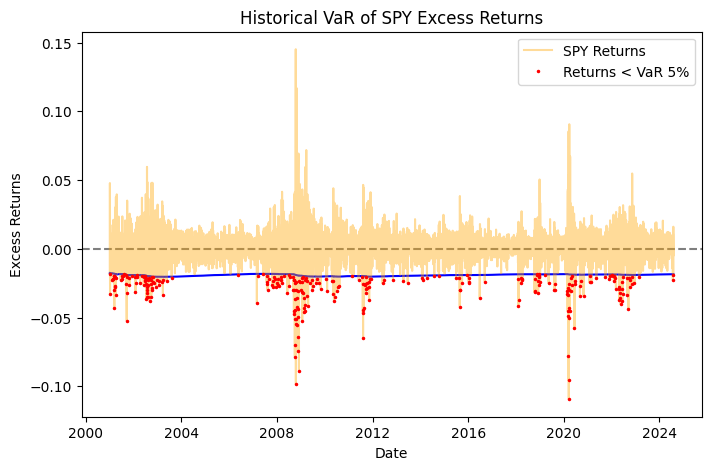

In [9]:
# Plot returns + VaR + (Returns < VaR): 
spy_excess_returns_surpass_var = (
    spy_excess_returns_var
    .dropna()
    .loc[lambda df: df["SPY"] < df["SPY Historical VaR 5%"]]
)

plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)

plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var["SPY Historical VaR 5%"].dropna(),
    color=COLORS[0]
)

plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var.dropna()["SPY"],
    color=COLORS[2],
    label="SPY Returns",
    alpha=.4 # transparency
)

plt.plot(
    spy_excess_returns_surpass_var.index,
    spy_excess_returns_surpass_var["SPY"],
    linestyle="",
    marker="o",
    color=COLORS[1],
    label="Returns < VaR 5%",
    markersize=1.5
)

#plt.ylim(min(spy_excess_returns_var["SPY"]), .005) # Uncomment to zoom in negative returns
plt.title("Historical VaR of SPY Excess Returns")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.show()

In [10]:
# Excess Return Analysis
spy_excess_returns_var_analysis = (
    spy_excess_returns_var
    .dropna()
    .assign(smaller=lambda df: df["SPY"] < df["SPY Historical VaR 5%"])
    .rename({"smaller": "Return < VaR 5%"}, axis=1)
)
spy_excess_returns_var_count = (spy_excess_returns_var_analysis
                                .groupby("Return < VaR 5%")["Return < VaR 5%"]
                                .agg(["count"])
                                .assign(percentage=lambda df: df['count'] / df['count'].sum(axis=0))
                                )

display(spy_excess_returns_var_count)
hit_ratio = spy_excess_returns_var_count.loc[True, 'percentage']
hit_ratio_error = abs(hit_ratio / .05 - 1)
print(f"Hit Ratio (frequency of returns < VaR 5%): {hit_ratio:.2%}\nHit Ratio Error: {hit_ratio_error:.2%}")


,count,percentage
Return < VaR 5%,,
False,5639,0.9514
True,288,0.0486


Hit Ratio (frequency of returns < VaR 5%): 4.86%
Hit Ratio Error: 2.82%


***

### Compare different VaR and CVaR Metrics

In [11]:
pm.calc_var_cvar_summary(spy_excess_returns, return_stats=['var']).dropna()

Using "window" of 60 periods, since none was specified
VaR and CVaR are given shifted by 1.000000 period(s).


,Returns,Expanding 60 Historical VaR (5.00%),Rolling 60 Historical VaR (5.00%),Expanding 60 Volatility,Rolling 60 Volatility,EWMA 0.94 Volatility,"GARCH(1, 1) Volatility",Expanding 60 Parametric VaR (5.00%),Rolling 60 Parametric VaR (5.00%),EWMA 0.94 Parametric VaR (5.00%),"GARCH(1, 1) Parametric VaR (5.00%)",Expanding 60 Historical CVaR (5.00%),Rolling 60 Historical CVaR (5.00%),Expanding 60 Parametrical CVaR (5.00%),Rolling 60 Parametrical CVaR (5.00%),EWMA 0.94 Parametrical CVaR (5.00%),"GARCH(1, 1) Parametrical CVaR (5.00%)"
date,,,,,,,,,,,,,,,,,
1994-03-31,-0.0140,-0.0134,-0.0134,0.0067,0.0067,0.0082,0.0097,-0.0109,-0.0109,-0.0135,-0.0159,-0.0189,-0.0189,-0.0137,-0.0137,-0.0169,-0.0200
1994-04-04,0.0027,-0.0134,-0.0134,0.0066,0.0066,0.0080,0.0103,-0.0109,-0.0109,-0.0131,-0.0170,-0.0189,-0.0189,-0.0136,-0.0137,-0.0165,-0.0213
1994-04-05,-0.0156,-0.0140,-0.0141,0.0068,0.0069,0.0086,0.0099,-0.0113,-0.0114,-0.0142,-0.0162,-0.0181,-0.0194,-0.0141,-0.0143,-0.0178,-0.0203
1994-04-06,0.0205,-0.0139,-0.0141,0.0073,0.0074,0.0098,0.0107,-0.0120,-0.0122,-0.0160,-0.0176,-0.0181,-0.0194,-0.0150,-0.0153,-0.0201,-0.0221
1994-04-07,-0.0001,-0.0139,-0.0141,0.0072,0.0074,0.0095,0.0120,-0.0119,-0.0121,-0.0156,-0.0197,-0.0181,-0.0194,-0.0149,-0.0152,-0.0195,-0.0247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,0.0110,-0.0185,-0.0079,0.0119,0.0066,0.0085,0.0104,-0.0196,-0.0109,-0.0139,-0.0172,-0.0284,-0.0153,-0.0246,-0.0136,-0.0174,-0.0216
2024-07-30,0.0004,-0.0185,-0.0079,0.0119,0.0066,0.0082,0.0105,-0.0196,-0.0108,-0.0135,-0.0172,-0.0284,-0.0153,-0.0246,-0.0136,-0.0169,-0.0216
2024-07-31,-0.0053,-0.0185,-0.0079,0.0119,0.0065,0.0081,0.0100,-0.0196,-0.0107,-0.0132,-0.0164,-0.0284,-0.0153,-0.0246,-0.0135,-0.0166,-0.0205


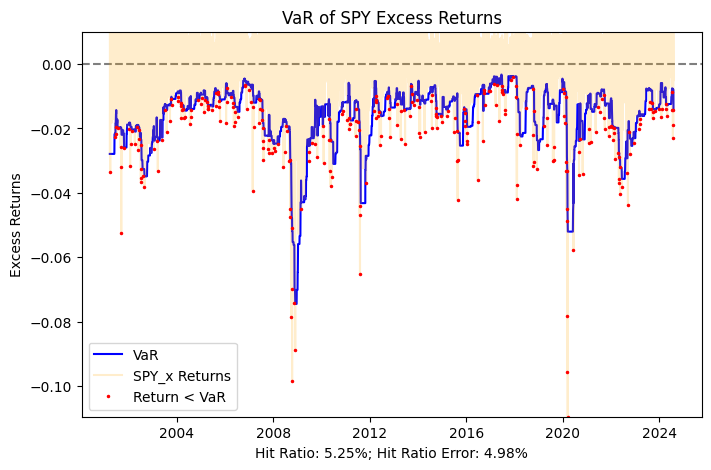

In [19]:
rolling_var = pm.rolling_var(spy_excess_returns, window=60)
pm.plot_var(spy_excess_returns, rolling_var, percentile=.05, figsize=(PLOT_WIDTH, PLOT_HEIGHT))

### 

***

### 

In [14]:
spy_excess_returns_var['SPY Historical VaR 5%']

date
2001-01-02   -0.0177
2001-01-03   -0.0178
2001-01-04   -0.0178
2001-01-05   -0.0178
2001-01-08   -0.0179
               ...  
2024-07-29   -0.0185
2024-07-30   -0.0185
2024-07-31   -0.0185
2024-08-01   -0.0185
2024-08-02   -0.0185
Name: SPY Historical VaR 5%, Length: 5927, dtype: float64

In [17]:
r = returns.to_frame()

In [20]:
type(spy_excess_returns_var['SPY Historical VaR 5%'])

pandas.core.series.Series

In [19]:
pd.merge(r, spy_excess_returns_var['SPY Historical VaR 5%'], left_index=True, right_index=True)

,SPY,SPY Historical VaR 5%
date,,
2001-01-02,-0.0183,-0.0177
2001-01-03,0.0478,-0.0178
2001-01-04,-0.0110,-0.0178
2001-01-05,-0.0328,-0.0178
2001-01-08,0.0075,-0.0179
...,...,...
2024-07-29,0.0004,-0.0185
2024-07-30,-0.0053,-0.0185
2024-07-31,0.0161,-0.0185


***

### 

***

### 